In [ ]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.decomposition import KernelPCA 
from sklearn.svm import SVC 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
import pandas as pd
import plotly.express as px
from torch import optim
import torch
from tqdm.notebook import tqdm
from torch import nn

In [ ]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install tqdm 

Note: you may need to restart the kernel to use updated packages.


In [ ]:
olive_data = fetch_olivetti_faces()
##image data
n_samples, h, w = olive_data.images.shape
data_size = h*w
X = olive_data.images.reshape(-1, data_size)
print("Number of images [{}], image width [{}], image height [{}] Width X Length [{}]".format(n_samples, h, w, data_size))
y = olive_data.target
n_classes = len(set(y))
print("number of classes[{}]".format(n_classes))

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Number of images [400], image width [64], image height [64] Width X Length [4096]
number of classes[40]


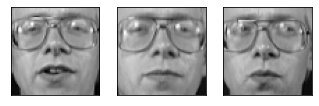

In [ ]:
def plot_gallery(images, item_index, n_col = 3, h=64, w=64, title=None): 
    if len(item_index) < n_col:
        n_row = len(item_index)
    
    plt.figure(figsize =(1.8 * n_col, 2.4))
    item_index = item_index[:n_col]
    #plt.subplots_adjust(bottom = 0, left =.01, right =.99, top =.90, hspace =.35) 
    for i in range(n_col): 
        plt.subplot(1, n_col, i + 1) 
        plt.imshow(images[item_index[i]].reshape(h, w), cmap = plt.cm.gray) 
        plt.xticks(()) 
        plt.yticks(())
    if title is not None:
        plt.suptitle(title)
        
## face selection
sample_index = 1
n_col = 3
itemindex = np.where(y==sample_index)[0]

## Face plot
plot_gallery(X, itemindex, n_col, h, w)

In [ ]:

pipe = Pipeline([('pca', KernelPCA(kernel="poly")), ('svc', SVC(class_weight ='balanced'))])

## to explore hyper-paramter cast setting
param_grid = {
    'pca__n_components': [20, 40, 60, 80, 100, 120, 140], ## Kernel-PCA parameter(n_components)
    'pca__degree': [2, 3, 4, 5], ## Kernel-PCA parameter(degree)
    'svc__C': [1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1, 8e-1, 9e-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1e1], ## SVM
} 

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X, olive_data.target, test_size=0.3, stratify=olive_data.target, random_state=0)

In [ ]:

clf = GridSearchCV(pipe, param_grid=param_grid)
clf = clf.fit(X_train, y_train)
print("Grid Search explored using Best hyper-parameter") 
print(clf.best_estimator_)

## Derive the result as a Dataframe
summary = pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

## Visualize the results
fig = px.bar(summary, x="pca__n_components", y="Accuracy", color="pca__n_components",
  animation_frame="svc__C", animation_group="pca__n_components", range_y=[0.5,1])
fig.show()

Grid Search explored using Best hyper-parameter
Pipeline(steps=[('pca', KernelPCA(kernel='poly', n_components=140)),
                ('svc', SVC(C=3, class_weight='balanced'))])


In [ ]:
y_pred = clf.predict(X_train) 
print("Training data performance [{}]".format(accuracy_score(y_train, y_pred)))

y_pred = clf.predict(X_test) 
print("Data Performance for Verification [{}]".format(accuracy_score(y_test, y_pred)))

Training data performance [1.0]
Data Performance for Verification [0.9083333333333333]


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size, class_size):
        super(NeuralNetwork, self).__init__()
        self.fc = nn.Sequential(
                    nn.BatchNorm1d(class_size),
                    nn.Linear(class_size, hidden_size),
                    nn.Tanh(),
                    nn.BatchNorm1d(hidden_size),
                    nn.Linear(hidden_size, class_size),
        )
    
    def forward(self, x, label=None):
        output = self.fc(x)
        return output

In [ ]:
class FaceRecognition(object):
    def __init__(self, pca, svm, hidden_size, class_size, learning_rate=0.001):
        ## PCA, SVM setting
        self.pca = pca
        self.svm = svm
        
        self.class_size = class_size
        
        ## Neural Network build
        self.network = NeuralNetwork(hidden_size, class_size)
        
        ## loss
        #self.loss = nn.MSELoss()
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.network.parameters(), lr=learning_rate)
    
    ## conversion function
    def transform(self, x, label=None):
        ## PCA data conversion using
        projected_x = self.pca.transform(x) 
        
        ## SVM Score Calculation
        class_scores = self.svm.decision_function(projected_x)
        
        ## Neural Network normalized to
        tensor_score = torch.tensor(class_scores, dtype=torch.float)
        output = self.network(tensor_score)
        
        ## Label Calculate the loss using
        if label is not None:
            label = torch.tensor(label, dtype=torch.long)
            
            ## MSE Calculate the loss using
            return self.loss(output, label)
        
        return output
    
    ## training function

    def fit(self, x, label):
        self.network.train()
        self.network.zero_grad()
        
        loss = self.transform(x, label)
        loss.backward()
        
        self.optimizer.step()
        return float(loss)
    
    ## function for prediction

    def predict(self, x):
        self.network.eval()
        with torch.no_grad():
            output = self.transform(x)
            
        output = output.argmax(dim=1).cpu().numpy()
        return output
    
    def raw_predict(self, x):
        ## PCA data conversion using
        projected_x = self.pca.transform(x) 
        
        ## SVM Score Calculation

        return self.svm.predict(projected_x)

In [ ]:
degree = clf.best_estimator_.get_params()['pca__degree']
n_components = clf.best_estimator_.get_params()['pca__n_components']
C = clf.best_estimator_.get_params()['svc__C']

svm = SVC(class_weight ='balanced', C=C)
pca = KernelPCA(kernel="poly", degree=degree, n_components=n_components)

## SVM, PCA Fitting
X_transformed = pca.fit_transform(X_train)
svm.fit(X_transformed, y_train) 
 
## Build the final model

hidden_size = 10
model = FaceRecognition(pca, svm, hidden_size=n_classes , class_size=n_classes, learning_rate=0.002) 
 
## training epoch setting
epochs = 300 

## to learn
progress_bar = tqdm(range(epochs), desc='Epoch')
for epoch in progress_bar:
    loss = model.fit(X_train, y_train)
    progress_bar.set_postfix_str("loss [{}]".format(loss))


## Final model performance evaluation
y_train_pred = model.predict(X_train)
print("Training data performance [{}]".format(accuracy_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print("Data Performance for Verification [{}]".format(accuracy_score(y_test, y_test_pred)))


Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Training data performance [1.0]
Data Performance for Verification [0.9083333333333333]
